## Data Sampling and Collection

In [205]:
import pandas as pd
import numpy as np
import gzip
import json
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

# for knn
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split
from collections import defaultdict

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from collections import defaultdict
from sklearn.model_selection import GridSearchCV

- raw review data for beauty

In [206]:
beauty_data = []
with gzip.open('../data/All_Beauty.json.gz') as data:
    for i in data:
        beauty_data.append(json.loads(i.strip()))

In [207]:
# the length of the data
print(len(beauty_data))
# the first row of the list
print(beauty_data[0])

371345
{'overall': 1.0, 'verified': True, 'reviewTime': '02 19, 2015', 'reviewerID': 'A1V6B6TNIC10QE', 'asin': '0143026860', 'reviewerName': 'theodore j bigham', 'reviewText': 'great', 'summary': 'One Star', 'unixReviewTime': 1424304000}


In [208]:
# transfer the list to data frame
beauty = pd.DataFrame.from_dict(beauty_data) 

In [209]:
beauty.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,1.0,True,"02 19, 2015",A1V6B6TNIC10QE,0143026860,theodore j bigham,great,One Star,1424304000,NaN,NaN,NaN
1,4.0,True,"12 18, 2014",A2F5GHSXFQ0W6J,0143026860,Mary K. Byke,My husband wanted to reading about the Negro Baseball and this a great addition to his library\n Our library doesn't haveinformation so this book is his start. Tthank you,... to reading about the Negro Baseball and this a great addition to his library Our library doesn't haveinformation so ...,1418860800,NaN,NaN,NaN
2,4.0,True,"08 10, 2014",A1572GUYS7DGSR,0143026860,David G,"This book was very informative, covering all aspects of game.",Worth the Read,1407628800,NaN,NaN,NaN
3,5.0,True,"03 11, 2013",A1PSGLFK1NSVO,0143026860,TamB,"I am already a baseball fan and knew a bit about the Negro leagues, but I learned a lot more reading this book.",Good Read,1362960000,NaN,NaN,NaN
4,5.0,True,"12 25, 2011",A6IKXKZMTKGSC,0143026860,shoecanary,"This was a good story of the Black leagues. I bought the book to teach in my high school reading class. I found it very informative and exciting. I would recommend to anyone interested in the history of the black leagues. It is well written, unlike a book of facts. The McKissack's continue to write good books for young audiences that can also be enjoyed by adults!","More than facts, a good story read!",1324771200,5,NaN,NaN


In [210]:
beauty.dropna().sample()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
263959,2.0,True,"03 21, 2018",A38UETRTGZZH17,B0014BB6WA,Sydney Holecek,Product has spilled out completely. It is all in my mailbox! This product needs to be sealed or taped before shipment. Picture shows the empty bottle floating in soap in the mailer.,Soap in MAILbox,1521590400,2,"{'Size:': ' 9 Ounce', 'Color:': ' Sensitive Skin'}",[https://images-na.ssl-images-amazon.com/images/I/71vu8Ou6grL._SY88.jpg]


- ratings only data for beauty

In [211]:
meta_beauty_data = []
with gzip.open('../data/meta_All_Beauty.json.gz') as metadata:
    for i in metadata:
        meta_beauty_data.append(json.loads(i.strip()))

In [212]:
# the length of the data
print(len(meta_beauty_data))
# the first row of the list
print(meta_beauty_data[0])

32892
{'category': [], 'tech1': '', 'description': ["Loud 'N Clear Personal Sound Amplifier allows you to turn up the volume on what people around you are saying, listen at the level you want without disturbing others, hear a pin drop from across the room."], 'fit': '', 'title': "Loud 'N Clear&trade; Personal Sound Amplifier", 'also_buy': [], 'tech2': '', 'brand': 'idea village', 'feature': [], 'rank': '2,938,573 in Beauty & Personal Care (', 'also_view': [], 'details': {'ASIN: ': '6546546450'}, 'main_cat': 'All Beauty', 'similar_item': '', 'date': '', 'price': '', 'asin': '6546546450', 'imageURL': [], 'imageURLHighRes': []}


In [213]:
# transfer the list to data frame
meta_beauty = pd.DataFrame.from_dict(meta_beauty_data)

In [214]:
meta_beauty.head()

category tech1  \
0       []         
1       []         
2       []         
3       []         
4       []         

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              description  \
0                                                                                                                                                                                                                                                                                                                                                                                                                           [Loud 'N Clear Personal Sound Amplifier allows you to turn up the volume on what people around you are saying, listen at the level you want without disturbing others, hear a pin drop from across the room.]   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 [No7 Lift & Luminate Triple Action Serum 50ml by Boots]   
2  [No7 Stay Perfect Foundation now stays perfect for longer! Up to 24 hours wear for non-stop complexion perfection. Life-proof foundation for a naturally flawless complexion with super-staying power, uniquely matched to your skin tone using No7 Stay Perfect. This comfortable foundation feels lightweight and breathable, and gives an even-toned, beautifully smooth complexion that looks and feels fresh all day long. It can be relied upon to stay perfect; weather-proof and transfer-proof, it won't cake or flake on dry skin, nor slide or shine on oily skin. Up to 24 hours wear for non stop complexion perfection!]   
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      []   
4                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 [Lacto Calamine Skin Balance Daily Nourishing Lotion - Oil Control (120ml) (Pack Of 2)]   

  fit                                                                   title  \
0                               Loud 'N Clear&trade; Personal Sound Ampli

In [215]:
meta_beauty.dropna().sample()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
13052,[],,[],,Marula Oil 2 oz. (FFP),[],,Shea Terra Organics,[],"847,621 in Beauty & Personal Care (",[],"{'Shipping Weight:': '9.6 ounces', 'ASIN: ': 'B00J9PPMD2'}",All Beauty,,,,B00J9PPMD2,[],[]


In [216]:
df_raw = pd.merge(beauty, meta_beauty[['title','asin']],on=['asin'], how='left')

In [217]:
df_raw.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,title
0,1.0,True,"02 19, 2015",A1V6B6TNIC10QE,0143026860,theodore j bigham,great,One Star,1424304000,NaN,NaN,NaN,NaN
1,4.0,True,"12 18, 2014",A2F5GHSXFQ0W6J,0143026860,Mary K. Byke,My husband wanted to reading about the Negro Baseball and this a great addition to his library\n Our library doesn't haveinformation so this book is his start. Tthank you,... to reading about the Negro Baseball and this a great addition to his library Our library doesn't haveinformation so ...,1418860800,NaN,NaN,NaN,NaN
2,4.0,True,"08 10, 2014",A1572GUYS7DGSR,0143026860,David G,"This book was very informative, covering all aspects of game.",Worth the Read,1407628800,NaN,NaN,NaN,NaN
3,5.0,True,"03 11, 2013",A1PSGLFK1NSVO,0143026860,TamB,"I am already a baseball fan and knew a bit about the Negro leagues, but I learned a lot more reading this book.",Good Read,1362960000,NaN,NaN,NaN,NaN
4,5.0,True,"12 25, 2011",A6IKXKZMTKGSC,0143026860,shoecanary,"This was a good story of the Black leagues. I bought the book to teach in my high school reading class. I found it very informative and exciting. I would recommend to anyone interested in the history of the black leagues. It is well written, unlike a book of facts. The McKissack's continue to write good books for young audiences that can also be enjoyed by adults!","More than facts, a good story read!",1324771200,5,NaN,NaN,NaN


In [218]:
df_raw["reviewTime"] = pd.to_datetime(df_raw["reviewTime"])

In [219]:
df_raw.dropna().sample()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,title
207983,3.0,True,2015-08-14,AA34XPQKKNRU3,B00W259T7G,Catherine E. Ingram,"The soap smells great and seems to work as soap should. However, the lavender soap has lots of lavender husks (I guess) and they get all over the place. So you have lots of little bits in the shower which annoys me. The other flavors of this soap that I have tried did not have that issue. Photo can help you see what I mean by bits.",Lavender only - is oddly messy,1439510400,93,"{'Size:': ' 250 Gram', 'Color:': ' Lavender'}",[https://images-na.ssl-images-amazon.com/images/I/61W+h6bwHmL._SY88.jpg],"Pre de Provence Artisanal French Soap Bar Enriched with Shea Butter, Quad-Milled For A Smooth &amp; Rich Lather (150 grams) - Raspberry"


## Data Cleaning

In [220]:
df_raw.shape

(387654, 13)

- remove unnecessary variables and missing data in some columns

In [221]:
df_raw.isnull().sum(axis = 0)

overall                0
verified               0
reviewTime             0
reviewerID             0
asin                   0
reviewerName          39
reviewText           404
summary              212
unixReviewTime         0
vote              332735
style             254712
image             379147
title               5122
dtype: int64

In [222]:
# remove image (1. too many nulls; 2. the links are useless)
df = df_raw.drop(columns=["image"], axis=1)

In [223]:
# remove missing data in reviewText
df.dropna(subset=['reviewText'], inplace=True)

In [224]:
df.isnull().sum(axis = 0)

overall                0
verified               0
reviewTime             0
reviewerID             0
asin                   0
reviewerName          39
reviewText             0
summary              196
unixReviewTime         0
vote              332389
style             254426
title               5118
dtype: int64

In [225]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 387250 entries, 0 to 387653
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   overall         387250 non-null  float64       
 1   verified        387250 non-null  bool          
 2   reviewTime      387250 non-null  datetime64[ns]
 3   reviewerID      387250 non-null  object        
 4   asin            387250 non-null  object        
 5   reviewerName    387211 non-null  object        
 6   reviewText      387250 non-null  object        
 7   summary         387054 non-null  object        
 8   unixReviewTime  387250 non-null  int64         
 9   vote            54861 non-null   object        
 10  style           132824 non-null  object        
 11  title           382132 non-null  object        
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1), object(8)
memory usage: 35.8+ MB


## EDA

- first we want to view the distribution of rating and verifing status.

In [226]:
df['overall'].value_counts(), df['overall'].value_counts(normalize=True)*100

(5.0    240056
 4.0     54967
 1.0     40595
 3.0     30591
 2.0     21041
 Name: overall, dtype: int64,
 5.0    61.989929
 4.0    14.194190
 1.0    10.482892
 3.0     7.899548
 2.0     5.433441
 Name: overall, dtype: float64)

<AxesSubplot:xlabel='overall', ylabel='count'>

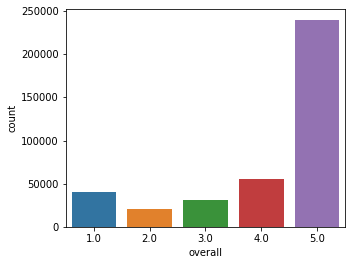

In [227]:
plt.figure(figsize=(5,4))
sns.countplot(x='overall', data=df)

In [228]:
df['verified'].value_counts(), df['verified'].value_counts(normalize=True)*100

(True     335487
 False     51763
 Name: verified, dtype: int64,
 True     86.633183
 False    13.366817
 Name: verified, dtype: float64)

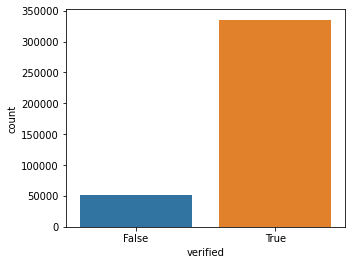

In [229]:
plt.figure(figsize=(5,4))
ax = sns.countplot(x='verified', data=df)

<AxesSubplot:xlabel='verified', ylabel='count'>

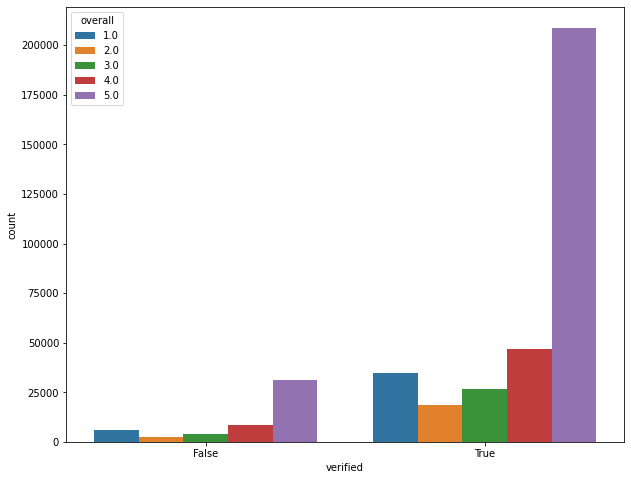

In [230]:
plt.figure(figsize=(10,8))
sns.countplot(x='verified', hue="overall", data=df)

- about 13.4% of the reviews haven't been verified. Some of them might be detected as fake review by amazon; the other may have haven't be processed by amazon review system.
- The distribution of ratings in verified and unverfied reviews are similar.

### coverting reviewtime to date format

In [231]:
df["reviewTime"] = pd.to_datetime(df["reviewTime"])

df_false = df.loc[df['verified'] == 'True']
df_false['reviewTime']

Series([], Name: reviewTime, dtype: datetime64[ns])

In [232]:
df['reviewTime'].min(), df['reviewTime'].max()

(Timestamp('2000-01-10 00:00:00'), Timestamp('2018-10-02 00:00:00'))

- all the reviews covered time frame from  Jan 10 2000 to Oct 2 2018.

In [233]:
yearcounts = df['reviewTime'].dt.year.value_counts().reset_index().rename(columns = {'index':'year', 'reviewTime':'reviewCount'}).astype('int')
yearcounts

,year,reviewCount
0,2016,103766
1,2017,72738
2,2015,71899
3,2014,41230
4,2018,31346
5,2013,27988
6,2012,10201
7,2011,7093
8,2010,5525
9,2009,4403


<AxesSubplot:xlabel='year', ylabel='reviewCount'>

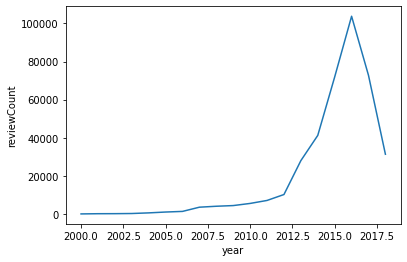

In [234]:
sns.lineplot(x = yearcounts['year'].astype(int), y = yearcounts['reviewCount'])

#### Reviewers

In [235]:
df['reviewerID'].nunique()

323687

- There're 323687 unique reviewers in our dataset.

In [236]:
df.groupby('reviewerID')['asin'].count().sort_values(ascending=False).head(100)

reviewerID
A2GJX2KCUSR0EI    27
A22CW0ZHY3NJH8    23
A1KSC91G9AIY2Z    23
A1EGCED01USBA9    21
AENH50GW3OKDA     20
                  ..
A2YB7DLC3FOR7W     8
A2MUGFV2TDQ47K     8
A10ZBR6O8S8OCY     8
AROYPRQ35VSAT      8
A35GLRQ89X0WRD     8
Name: asin, Length: 100, dtype: int64

- The reviewer A2GJX2KCUSR0EI reviewed 27 products, which was the most across all reviewers.
- The top 100 reviewers in beauty department reviewed 8 or more products.

In [237]:
df.groupby('reviewerID')['vote'].count().sort_values(ascending=False).head(100)

reviewerID
ABLOQZIL42W7I     14
A2GJX2KCUSR0EI    13
A1L0QECT7J93ZP    10
AENH50GW3OKDA     10
A1JDBXPK20HBUW     9
                  ..
AMUVF6UQZ6UCO      5
A2QCHBEXUBN2S8     5
A31N0XY2UTB25C     5
AFNE6AFYU3ZVD      5
A3OOKCY6BCRNAT     5
Name: vote, Length: 100, dtype: int64

#### Products

In [238]:
df['asin'].nunique()

32571

In [239]:
df.groupby('asin')['reviewerID'].count().sort_values(ascending=False).head(100)

asin
B000FOI48G    8671
B000GLRREU    8340
1620213982    4789
B001QY8QXM    4544
B00005JS5C    4498
              ... 
B00IIZG80U     395
B019FOXB70     393
B018WCT01C     393
B00592MMPA     392
B016QSRYR6     392
Name: reviewerID, Length: 100, dtype: int64

In [240]:
meta_beauty[meta_beauty['asin']=='B000FOI48G']

category tech1  \
1254       []         

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [241]:
#pd.set_option('display.max_colwidth', None)
meta_beauty[meta_beauty['asin']=='B000FOI48G']['imageURLHighRes']

1254    [https://images-na.ssl-images-amazon.com/images/I/31xtQMrz7dL.jpg]
Name: imageURLHighRes, dtype: object

- The product B000FOI48G has been reviewed by 8671 reviewers. It is a Waterpik dental water jet.	
- The top 100 popular products in beauty department have been reviewed by 392 or more unique reviewers.

In [242]:
meta_beauty.groupby('brand')['asin'].count().sort_values(ascending=False).head(100)

brand
                      15673
VAGA                    252
L'Oreal Paris           113
Philips Norelco          88
Gillette                 83
                      ...  
Icarus                   17
CHANEL                   16
LCL Beauty               16
Physicians Formula       16
Queen Helene             16
Name: asin, Length: 100, dtype: int64

- 15673 of the products do not have a brand. Among those have a specified brand, 252 of the products were from VAGA, and 113 of the products were from L'Oreal Paris.

In [243]:
meta_beauty['rank']

0        2,938,573 in Beauty & Personal Care (
1          872,854 in Beauty & Personal Care (
2          956,696 in Beauty & Personal Care (
3        1,870,258 in Beauty & Personal Care (
4           67,701 in Beauty & Personal Care (
                         ...                  
32887    2,145,325 in Beauty & Personal Care (
32888    1,639,713 in Beauty & Personal Care (
32889      207,410 in Beauty & Personal Care (
32890      965,673 in Beauty & Personal Care (
32891      478,123 in Beauty & Personal Care (
Name: rank, Length: 32892, dtype: object

### Sentiment Analysis

In [244]:
# classify postive and negative reviews to 1, and 0
def classify_overall(overall):
    if overall >= 3.5:
        return 1
    else:
        return 0

In [245]:
df['overall_sentiment'] = df['overall'].apply(classify_overall)

In [246]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,title,overall_sentiment
0,1.0,True,2015-02-19,A1V6B6TNIC10QE,0143026860,theodore j bigham,great,One Star,1424304000,NaN,NaN,NaN,0
1,4.0,True,2014-12-18,A2F5GHSXFQ0W6J,0143026860,Mary K. Byke,My husband wanted to reading about the Negro Baseball and this a great addition to his library\n Our library doesn't haveinformation so this book is his start. Tthank you,... to reading about the Negro Baseball and this a great addition to his library Our library doesn't haveinformation so ...,1418860800,NaN,NaN,NaN,1
2,4.0,True,2014-08-10,A1572GUYS7DGSR,0143026860,David G,"This book was very informative, covering all aspects of game.",Worth the Read,1407628800,NaN,NaN,NaN,1
3,5.0,True,2013-03-11,A1PSGLFK1NSVO,0143026860,TamB,"I am already a baseball fan and knew a bit about the Negro leagues, but I learned a lot more reading this book.",Good Read,1362960000,NaN,NaN,NaN,1
4,5.0,True,2011-12-25,A6IKXKZMTKGSC,0143026860,shoecanary,"This was a good story of the Black leagues. I bought the book to teach in my high school reading class. I found it very informative and exciting. I would recommend to anyone interested in the history of the black leagues. It is well written, unlike a book of facts. The McKissack's continue to write good books for young audiences that can also be enjoyed by adults!","More than facts, a good story read!",1324771200,5,NaN,NaN,1


In [247]:
df['overall_sentiment'].value_counts()

1    295023
0     92227
Name: overall_sentiment, dtype: int64

In [248]:
df["verified"] = df["verified"].astype(int)      

- Remove the punctuation from each tweet so we can analyze the words.

In [249]:
punct_re = r'[^\w\s]'
def sanitize_texts(df):
    df["clean_reviewText"] = df['reviewText'].str.lower().str.replace(pat=punct_re, repl=" ")
    return df
df = sanitize_texts(df)
df.head()

C:\Users\yifan\AppData\Local\Temp/ipykernel_14512/2989083077.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df["clean_reviewText"] = df['reviewText'].str.lower().str.replace(pat=punct_re, repl=" ")


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,title,overall_sentiment,clean_reviewText
0,1.0,1,2015-02-19,A1V6B6TNIC10QE,0143026860,theodore j bigham,great,One Star,1424304000,NaN,NaN,NaN,0,great
1,4.0,1,2014-12-18,A2F5GHSXFQ0W6J,0143026860,Mary K. Byke,My husband wanted to reading about the Negro Baseball and this a great addition to his library\n Our library doesn't haveinformation so this book is his start. Tthank you,... to reading about the Negro Baseball and this a great addition to his library Our library doesn't haveinformation so ...,1418860800,NaN,NaN,NaN,1,my husband wanted to reading about the negro baseball and this a great addition to his library\n our library doesn t haveinformation so this book is his start tthank you
2,4.0,1,2014-08-10,A1572GUYS7DGSR,0143026860,David G,"This book was very informative, covering all aspects of game.",Worth the Read,1407628800,NaN,NaN,NaN,1,this book was very informative covering all aspects of game
3,5.0,1,2013-03-11,A1PSGLFK1NSVO,0143026860,TamB,"I am already a baseball fan and knew a bit about the Negro leagues, but I learned a lot more reading this book.",Good Read,1362960000,NaN,NaN,NaN,1,i am already a baseball fan and knew a bit about the negro leagues but i learned a lot more reading this book
4,5.0,1,2011-12-25,A6IKXKZMTKGSC,0143026860,shoecanary,"This was a good story of the Black leagues. I bought the book to teach in my high school reading class. I found it very informative and exciting. I would recommend to anyone interested in the history of the black leagues. It is well written, unlike a book of facts. The McKissack's continue to write good books for young audiences that can also be enjoyed by adults!","More than facts, a good story read!",1324771200,5,NaN,NaN,1,this was a good story of the black leagues i bought the book to teach in my high school reading class i found it very informative and exciting i would recommend to anyone interested in the history of the black leagues it is well written unlike a book of facts the mckissack s continue to write good books for young audiences that can also be enjoyed by adults


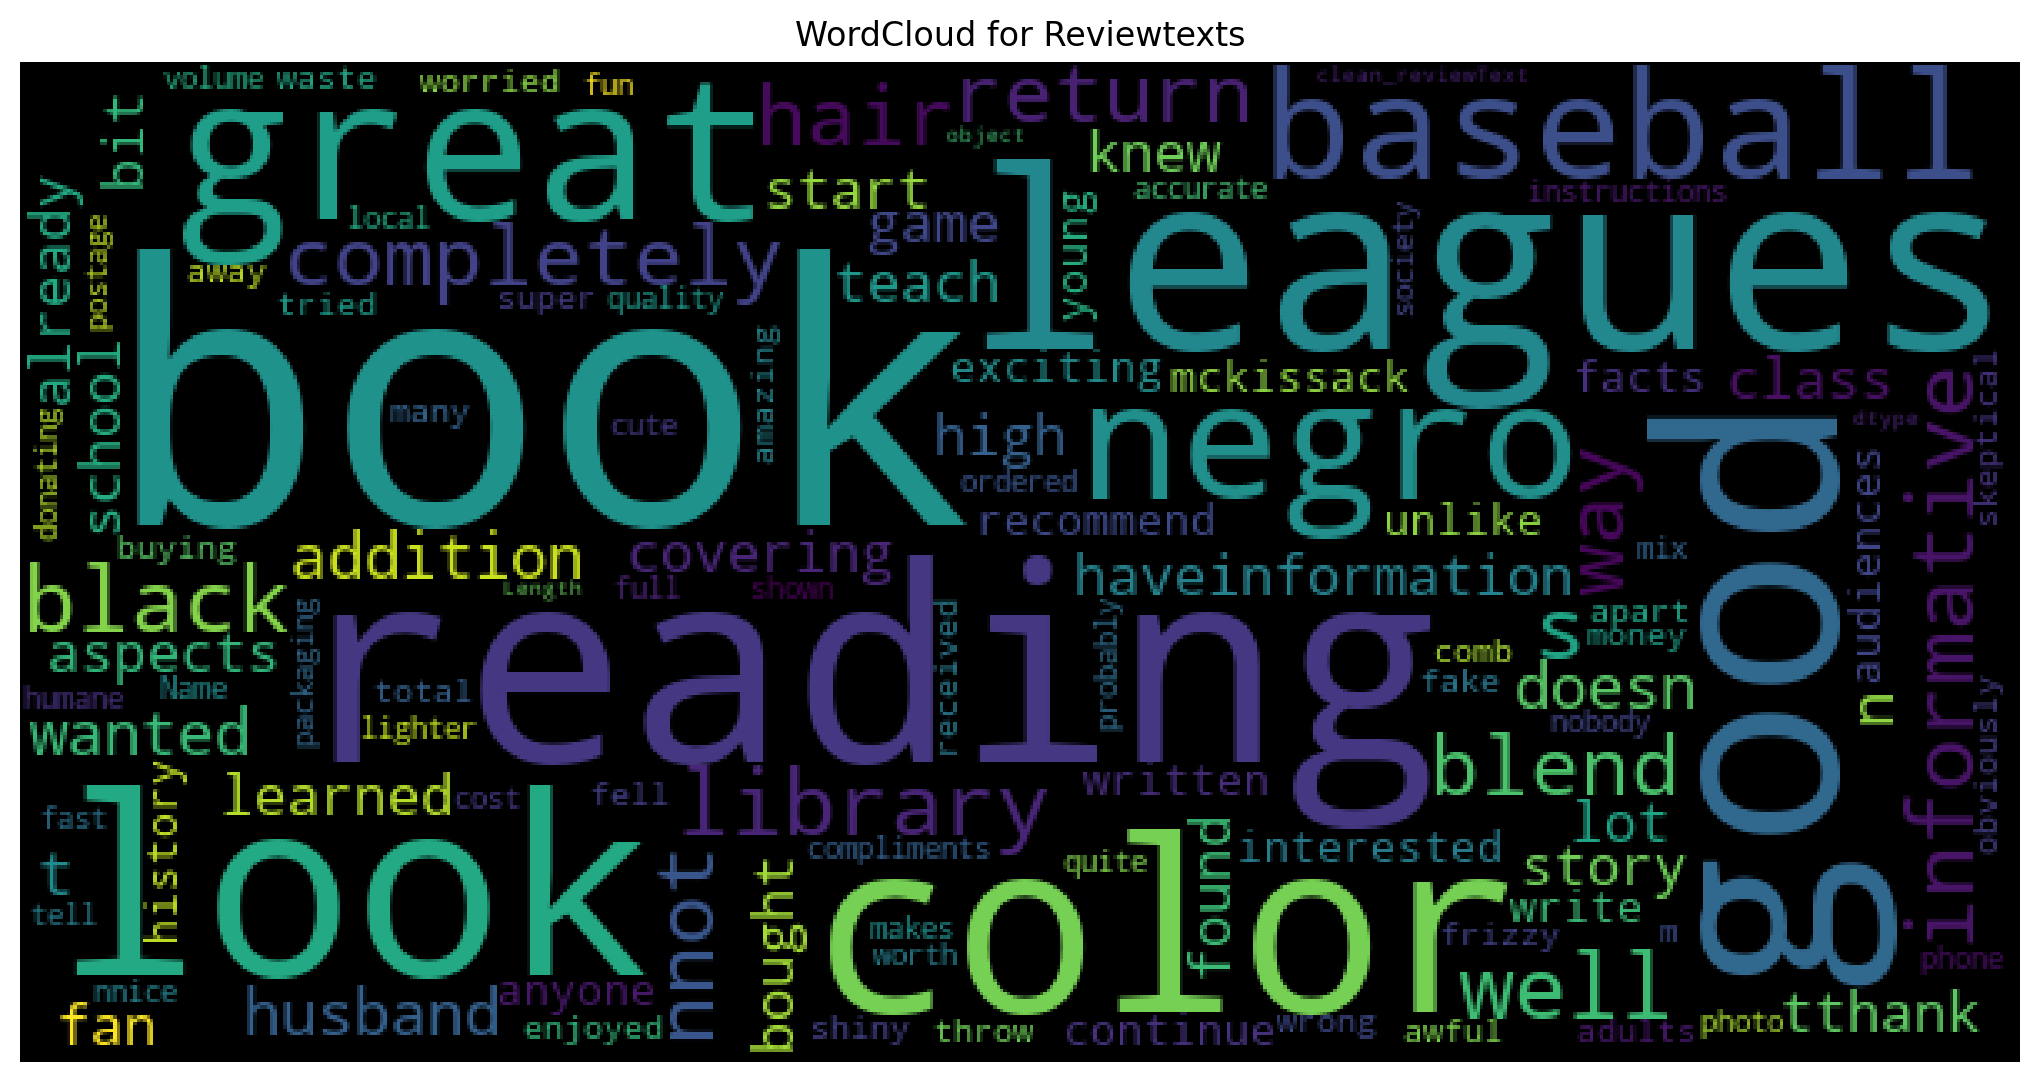

In [250]:
wc = WordCloud(width=600,height=300)
cld = wc.generate(str(df["clean_reviewText"]))
plt.figure(figsize=(10,5), dpi=200)
plt.imshow(cld)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('WordCloud for Reviewtexts')
plt.show()

- Remove stopwords so we can get useful words

In [251]:
stop_words = set(stopwords.words("english"))

- The top 25 frequent words in positive reviews

In [252]:
temp_pos = df[df['overall_sentiment'] == 1]['clean_reviewText'].str.split().to_numpy() 
words1 = {}
for i in range(len(temp_pos)):
    temp_pos[i] = [s for s in temp_pos[i] if s not in stop_words]
    for j in temp_pos[i]:
        if j not in words1:
            words1[j] = 1
        else:
            words1[j] += 1
pos_words = pd.DataFrame(sorted(words1.items(), key = lambda x: x[1], reverse=True))
pos_words_top25 = pos_words.head(25)
pos_words_top25.columns = ['words', 'counts']
pos_words_top25

,words,counts
0,product,82054
1,great,80692
2,love,65294
3,use,62474
4,like,53789
5,good,51126
6,hair,48876
7,skin,47458
8,one,45229
9,well,38422


C:\Users\yifan\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Top 25 Frequent Words in Postive Reviews'}, xlabel='words', ylabel='counts'>

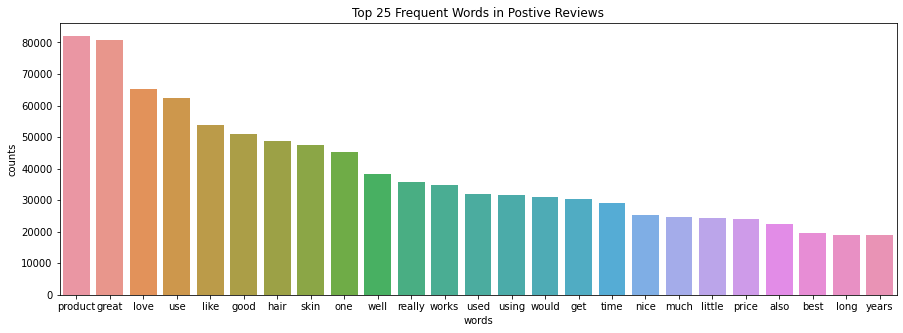

In [253]:
plt.figure(figsize=(15,5))
plt.title('Top 25 Frequent Words in Postive Reviews')
sns.barplot('words','counts', data = pos_words_top25)

- The top 25 frequent words in negative reviews

In [254]:
temp_neg = df[df['overall_sentiment'] == 0]['clean_reviewText'].str.split().to_numpy() 
words3 = {}
for i in range(len(temp_neg)):
    temp_neg[i] = [s for s in temp_neg[i] if s not in stop_words]
    for j in temp_neg[i]:
        if j not in words3:
            words3[j] = 1
        else:
            words3[j] += 1
neg_words = pd.DataFrame(sorted(words3.items(), key = lambda x: x[1], reverse=True))
neg_words_top25 = neg_words.head(25)
neg_words_top25.columns = ['words', 'counts']
neg_words_top25

,words,counts
0,product,25173
1,like,21062
2,one,16231
3,hair,15587
4,use,15475
5,would,14993
6,get,12506
7,good,12137
8,work,10663
9,used,10078


C:\Users\yifan\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Top 25 Frequent Words in Negative Reviews'}, xlabel='words', ylabel='counts'>

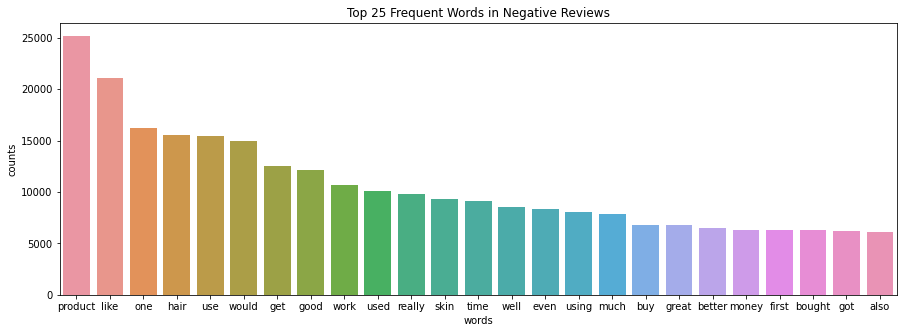

In [255]:
plt.figure(figsize=(15,5))
plt.title('Top 25 Frequent Words in Negative Reviews')
sns.barplot('words','counts', data = neg_words_top25)

## Methodology

In [256]:
# Train-Test Split
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)

### K-Nearest Neighbors Classification

#### Product Based

In [257]:
df2 = df[['asin', 'overall', 'clean_reviewText']]
df2.shape

(387250, 3)

In [258]:
df2.head()

,asin,overall,clean_reviewText
0,0143026860,1.0,great
1,0143026860,4.0,my husband wanted to reading about the negro baseball and this a great addition to his library\n our library doesn t haveinformation so this book is his start tthank you
2,0143026860,4.0,this book was very informative covering all aspects of game
3,0143026860,5.0,i am already a baseball fan and knew a bit about the negro leagues but i learned a lot more reading this book
4,0143026860,5.0,this was a good story of the black leagues i bought the book to teach in my high school reading class i found it very informative and exciting i would recommend to anyone interested in the history of the black leagues it is well written unlike a book of facts the mckissack s continue to write good books for young audiences that can also be enjoyed by adults


- Select products which have more than 5 reviews

In [259]:
df2 = df2.groupby('asin').filter(lambda sf: len(sf) > 5)
df2.shape

(340485, 3)

- Group all reviews by products

In [260]:
df2_sub = df2.groupby('asin', as_index=False).mean()
df2_sub = df2_sub
df2_sub.shape

(7682, 2)

In [261]:
df2_sub.head()

,asin,overall
0,0143026860,4.117647
1,014789302X,4.315789
2,0977949125,5.000000
3,0992916305,4.937500
4,0996607404,5.000000


In [262]:
df3 = pd.merge(df2, df2_sub, on="asin", how='inner')

In [263]:
df3 = df3[['asin','clean_reviewText','overall_y']]
df3.columns = ['asin','clean_reviewText','overall']
df3.head()

,asin,clean_reviewText,overall
0,0143026860,great,4.117647
1,0143026860,my husband wanted to reading about the negro baseball and this a great addition to his library\n our library doesn t haveinformation so this book is his start tthank you,4.117647
2,0143026860,this book was very informative covering all aspects of game,4.117647
3,0143026860,i am already a baseball fan and knew a bit about the negro leagues but i learned a lot more reading this book,4.117647
4,0143026860,this was a good story of the black leagues i bought the book to teach in my high school reading class i found it very informative and exciting i would recommend to anyone interested in the history of the black leagues it is well written unlike a book of facts the mckissack s continue to write good books for young audiences that can also be enjoyed by adults,4.117647


In [264]:
df3 = df3.drop_duplicates(['overall'], keep='last')
df3

,asin,clean_reviewText,overall
4840,1620213982,this product is nice and shiny good weight and fit my mercur razor and brush nicely would recommend buying this if you need a good solid stand,4.798288
4993,9790787006,i had such high hopes for this perfume it kept popping up in my recommendations and the reviews made me curious \nwell curiosity definitely killed the cat while jenna bottled the preserved stench \nthis smells terrible so bad that it actually gave me a headache each time i smelled it \ni m all for darker scents black orchid anyone but this is unbearable as well as unwearable to me \ni love jenna but to the trash this went,4.228070
5149,B000050FDR,about fives years ago i bought a panasonic wet dry shaver it s very good but there was something wrong with the battery half a year ago so i had to buy a new one_norelco 6886xl althought it s not bad i don t like it it s too big and not convenient for travelling specially i don t like the way it works and the speed of rotation seems too slowly just like run out of power immediately so i have to find a new one instead even if it s not broken \nwhen i had a glance on bruan 7570 by accident i believe it s the shaver i ve been looking for it s perfect design specially the pattern and the function and the battery life is longer than the 6886xl i think there is no need to be worried about it s effectiveness after i read the other customer reviews listed here \nthe only thing i worried about is the clean charge i hope it can last for a long time,3.805556
5457,B000050B6B,i don t like to give anything a really bad review but i have to give these a 1 star or less they may say phillips norelco on the box but they ran loose and loud in the razor and just scraped the heck out of my face do not waste you money on these blades i just threw them right in the trash,4.441558
8529,B000050FDY,contrary to comments about this delivery service and product i ve ordered this identical product from the same provider each lasts over a month cleaning 2 braun razors and the product works perfectly not a copy of the product it is the real thing and it works beautifully,4.651042
...,...,...,...
340451,B01HELYEIQ,i was so confused when i first received this because it is covered by stickers so it looks cardboard and then you have to put it together which isn t a big deal now that i finally figured it out i really like it and i think it looks sleek and cute,3.500000
340461,B01HFMB6EE,it s okay not worth the money i don t think i have better success with drugstore mascara,2.400000
340471,B01HFWIKH0,my 6 year old son tried the kid s crest cavity protection toothpaste in bubble gum flavor he loved it in his words the flavor was good and not too spicy we ve had challenges before with mint flavors which he considers too spicy dispenses from the tube easily and cleanly this one is a winner thanks to crest for providing the product free in exchange for my honest review,4.800000
340477,B01HHWQX8G,i really love this it even pierced through my cartilage,4.166667


In [265]:
reviews = df3["clean_reviewText"] 
countVector = CountVectorizer(stop_words="english", max_features=400)
transformedReviews = countVector.fit_transform(reviews) 

df_reviews = pd.DataFrame(transformedReviews.A, columns=countVector.get_feature_names())
df_reviews = df_reviews.astype(int)

C:\Users\yifan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [266]:
df_reviews.head()

,10,100,30,able,absolutely,acne,actually,add,advertised,ago,...,work,worked,working,works,worth,wouldn,wrap,year,years,yes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,2,...,0,0,0,1,0,0,0,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0


In [267]:
# Train-Test Split
from sklearn.model_selection import train_test_split
dfReviews_train, dfReviews_test = train_test_split(df_reviews, test_size=0.2, random_state=42)

In [268]:
len_train = len(dfReviews_train)
len_test = len(dfReviews_test)

In [269]:
print(len_train)
print(len_test)

1445
362


- Find the k_neighbors of each product

In [270]:
neighbor = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(dfReviews_train)

distances, indices = neighbor.kneighbors(dfReviews_train)

- Take one product and its most similar products as examples

In [271]:
related_products = neighbor.kneighbors([dfReviews_test.iloc[1, :]])[1]
first_similar_product = [item[0] for item in related_products]
first_similar_product = str(first_similar_product).strip('[]')
first_similar_product = int(first_similar_product)
second_similar_product = [item[1] for item in related_products]
second_similar_product = str(second_similar_product).strip('[]')
second_similar_product = int(second_similar_product)
print ("Based on reviews, for product", df3["asin"].iloc[len_train + 1] ," average rating is ",df3["overall"].iloc[len_train + 1])
print ("The first similar product is ", df3["asin"].iloc[first_similar_product] ," average rating is ",df3["overall"].iloc[first_similar_product])
print ("The second similar product is ", df3["asin"].iloc[second_similar_product] ," average rating is ",df3["overall"].iloc[second_similar_product])

Based on reviews, for product B01E54U1RI  average rating is  4.25531914893617
The first similar product is  B01E21CEXS  average rating is  3.0625
The second similar product is  B001AMRQ2W  average rating is  4.073394495412844


C:\Users\yifan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [272]:
# Train-Test Split
from sklearn.model_selection import train_test_split
df3_train, df3_test = train_test_split(df3, test_size=0.2, random_state=42)
df3_train["overall"] = df3_train["overall"].apply(classify_overall)
df3_test["overall"] = df3_test["overall"].apply(classify_overall)
df3_train_y = df3_train["overall"]
df3_test_y = df3_test["overall"]
df3_train_x = df3_train.drop(['overall'], axis=1)
df3_test_x = df3_test.drop(['overall'], axis=1)

In [273]:
knn2 = KNeighborsClassifier(n_neighbors=5, weights='distance')
param_grid = {'n_neighbors': np.arange(1, 25)}
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
knn_gscv.fit(dfReviews_train, df3_train_y)
pred_test = knn_gscv.predict(dfReviews_test)

C:\Users\yifan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\yifan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\yifan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\yifan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\yifan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature name

- The best n_neighbors value

In [274]:
knn_gscv.best_params_

{'n_neighbors': 21}

- The mean score for the best modeling

In [275]:
knn_gscv.best_score_

0.7307958477508649

##### Model Performance

In [276]:
cnf1 = confusion_matrix(df3_test_y, pred_test)
cnf1

array([[  9,  96],
       [  6, 251]], dtype=int64)

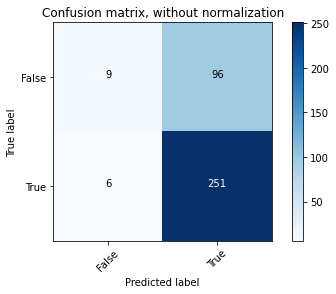

In [277]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    import itertools

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid(False)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, np.round(cm[i, j], 2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
class_names = ['False', 'True']

plot_confusion_matrix(cnf1, classes=class_names,
                      title='Confusion matrix, without normalization')

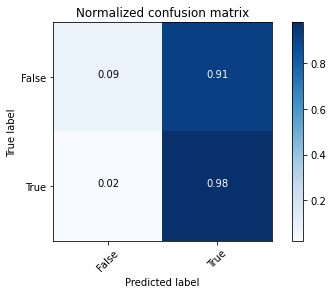

In [278]:
cnf1_norm = cnf1/np.sum(cnf1, axis = 1, keepdims = True)
plot_confusion_matrix(cnf1_norm, classes=class_names,
                       title='Normalized confusion matrix')

In [279]:
tn, fp, fn, tp = confusion_matrix(df3_test_y, pred_test).ravel()
print(tn, fp, fn, tp)

9 96 6 251


In [280]:
# Accuracy
print ("Accuracy is", (tp+tn)/(tn + fp + fn + tp))
# TPR (True Positive Rate) or Recall
print ("TPR (True Positive Rate) or Recall,", tp/(tp+fn))
# TNR (True Negative Rate):
print("TNR (True Negative Rate),", tn/(fp+tn))
# FPR (False Positive Rate):
print("FPR (False Positive Rate),", fp/(fp+tn))
# FNR (False negative Rate):
print("FNR (False negative Rate),", fn/(tp+fn))
print("MSE: ",mean_squared_error(df3_test_y, pred_test))

Accuracy is 0.7182320441988951
TPR (True Positive Rate) or Recall, 0.9766536964980544
TNR (True Negative Rate), 0.08571428571428572
FPR (False Positive Rate), 0.9142857142857143
FNR (False negative Rate), 0.023346303501945526
MSE:  0.281767955801105


#### Collaborative Filtering

- Though we have a large dataset, lets consider ratings provided by user who have rated more than 2 products. The reasons are:
    - We may not be able to understand or rely on a rating with fewer number of representation from the reviewers. For example, if a product has received only a single rating or a reviewer has rated only one product it may not be enough for us to define similarity of the products or reviewers.
    - Memory consideration: collaborative filtering methods could become compuationally complex with the local machines on a high volume dataset, and my computer failed to handle the whole dataset.

In [281]:
df1 = df[['reviewerID', 'asin', 'overall']]
df1.shape

(387250, 3)

In [282]:
df1_sub = df1.groupby('reviewerID').filter(lambda sf: len(sf) > 2).groupby('asin').filter(lambda sf: len(sf) > 2)
df1_sub.shape

(26738, 3)

In [283]:
df1_sub.head()

,reviewerID,asin,overall
170,A3GAN4X1TF8TPY,1620213982,4.0
213,A3F5DIB5CVJAT0,1620213982,5.0
242,AD1358H3YF65O,1620213982,5.0
325,A2T0GWSZFLUZE3,1620213982,5.0
351,A3NCIN6TNL0MGA,1620213982,5.0


In [284]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
df2 = Dataset.load_from_df(df1_sub,reader)
df2

In [285]:
#Splitting the dataset
from surprise.model_selection import train_test_split
train, test = train_test_split(df2, test_size=0.2, random_state=42)

In [286]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
beauty_knn = KNNWithMeans(sim_options={'name': 'cosine', 'user_based': True}) # Compute  similarities between users
beauty_knn.fit(train)

Computing the cosine similarity matrix...
Done computing similarity matrix.


- parameters
  - `k`: default was 40
  - `name` means the similarity metric to use. Options includes cosine, msd, pearson, or pearson_baseline. The default is msd.
  - `min_support` is the minimum number of common items needed between users to consider them for similarity. 
  - `user_based` is a boolean arhgument: whether the approach will be user-based or item-based. The default is True, which means the user-based approach will be used.

In [287]:
# run the trained model against the testset
test_pred = beauty_knn.test(test)

In [288]:
test_pred[0]

Prediction(uid='A1FVUI9HJFGRSF', iid='B000209JS2', r_ui=5.0, est=5, details={'actual_k': 40, 'was_impossible': False})

- The prediction shows that the user 'A1FVUI9HJFGRSF' will rate the product 'B000209JS2' 5.0, which indicates a high rank in recommendation. 
- The prediction rating is very close to the true rating `r_ui = 5.0`, which also suggests a high accuracy.

##### Tuning the Algorithm Parameters

- Surprise provides a GridSearchCV class that tries all the combinations of parameters and reports the best parameters for any accuracy measure

In [289]:
from surprise.model_selection import GridSearchCV

sim_options = {
    "name": ["msd", "cosine"],
    "min_support": [3, 4, 5],
    "user_based": [False, True],
}

param_grid = {
    "k": [20, 40, 60, 100, 200, 400],
    "sim_options": sim_options
}

gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse", "mae"], cv=5)
gs.fit(df2)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [290]:
print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

0.6832367053958995
{'k': 20, 'sim_options': {'name': 'msd', 'min_support': 5, 'user_based': False}}


- So, for our dataset, Centered-KNN algorithm works best if you use 
  -  20 nearest neighbors to predict the value
  -  use msd as the similarity metric
  -  item-based approach
  -  minimum support 5.
- The rmse of the optimal model is 0.8606.

In [291]:
gs.cv_results['params'], gs.cv_results['mean_test_rmse']

([{'k': 20,
   'sim_options': {'name': 'msd', 'min_support': 3, 'user_based': False}},
  {'k': 20,
   'sim_options': {'name': 'msd', 'min_support': 3, 'user_based': True}},
  {'k': 20,
   'sim_options': {'name': 'msd', 'min_support': 4, 'user_based': False}},
  {'k': 20,
   'sim_options': {'name': 'msd', 'min_support': 4, 'user_based': True}},
  {'k': 20,
   'sim_options': {'name': 'msd', 'min_support': 5, 'user_based': False}},
  {'k': 20,
   'sim_options': {'name': 'msd', 'min_support': 5, 'user_based': True}},
  {'k': 20,
   'sim_options': {'name': 'cosine', 'min_support': 3, 'user_based': False}},
  {'k': 20,
   'sim_options': {'name': 'cosine', 'min_support': 3, 'user_based': True}},
  {'k': 20,
   'sim_options': {'name': 'cosine', 'min_support': 4, 'user_based': False}},
  {'k': 20,
   'sim_options': {'name': 'cosine', 'min_support': 4, 'user_based': True}},
  {'k': 20,
   'sim_options': {'name': 'cosine', 'min_support': 5, 'user_based': False}},
  {'k': 20,
   'sim_options': {'n

##### Build the model with greatest accuracy

In [292]:
beauty_knn_optimal = KNNWithMeans(k=20, sim_options={'name': 'msd', 'min_support': 5, 'user_based': False}) # Compute  similarities between users
beauty_knn_optimal.fit(train)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [293]:
# run the trained model against the testset
test_pred_optimal = beauty_knn_optimal.test(test)

In [294]:
accuracy.rmse(test_pred_optimal)

RMSE: 0.6764


0.6764026644119849

- The RMSE in the test data is 0.6764.

In [295]:
test_pred_optimal[0]

Prediction(uid='A1FVUI9HJFGRSF', iid='B000209JS2', r_ui=5.0, est=4.979172913543229, details={'actual_k': 2, 'was_impossible': False})

- The prediction shows that the user 'A1FVUI9HJFGRSF' will rate the product 'B000209JS2' 5.0, which indicates a high rank in recommendation. 
- The prediction rating is the same asthe true rating `r_ui = 5.0`, which suggests a high accuracy.

In [296]:
test_pred_optimal[15]

Prediction(uid='AV67K57HQDTT1', iid='B0001D35FI', r_ui=3.0, est=3.0, details={'actual_k': 1, 'was_impossible': False})

- The prediction shows that the user 'AV67K57HQDTT1' will rate the product 'B0001D35FI' 3.0, which indicates the product should be ranked low in recommendation. 
- The prediction rating is the same as the true rating `r_ui = 3.0`, which also suggests a high accuracy.

In [297]:
test_pred_optimal[60]

Prediction(uid='A2A6SQ79Z62GHF', iid='B019809F9Y', r_ui=5.0, est=4.4760168302945305, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

- Due to the small dataset we are using (and the train-test split), some user and/or item is unknown from our trainset. So the prediction of and unknown reviewer may be impossible.

##### Quantifying Performance

In [298]:
out = pd.DataFrame(test_pred_optimal, columns=['uid', 'iid', 'rui', 'est', 'details'])    
out['err'] = abs(out.est - out.rui)
out

,uid,iid,rui,est,details,err
0,A1FVUI9HJFGRSF,B000209JS2,5.0,4.979173,"{'actual_k': 2, 'was_impossible': False}",0.020827
1,A1EZEHP6WTB5DT,B0001TMDF0,5.0,5.000000,"{'actual_k': 1, 'was_impossible': False}",0.000000
2,A92715DKA7G12,B000142J2W,5.0,5.000000,"{'actual_k': 1, 'was_impossible': False}",0.000000
3,A80A8PCDT0NFB,B0012Y0ZG2,5.0,5.000000,"{'actual_k': 6, 'was_impossible': False}",0.000000
4,A1TIOMXYCPV5PU,B00009RB1C,5.0,4.741935,"{'actual_k': 0, 'was_impossible': False}",0.258065
...,...,...,...,...,...,...
5343,A37SCK1NEZF59D,B00T4JR96Q,2.0,4.476017,"{'was_impossible': True, 'reason': 'User and/or item is unknown.'}",2.476017
5344,A2WR0HJ3GFM0NM,B00021DJ32,5.0,5.000000,"{'actual_k': 1, 'was_impossible': False}",0.000000
5345,A3KQXBK8QIX87F,B0000530HU,5.0,5.000000,"{'actual_k': 1, 'was_impossible': False}",0.000000
5346,A3E3GD3TABXKU1,B0019ZD61A,5.0,4.400000,"{'actual_k': 0, 'was_impossible': False}",0.600000


In [299]:
best_predictions = out.sort_values(by='err')[:10]
worst_predictions = out.sort_values(by='err')[-50:]

In [300]:
best_predictions

,uid,iid,rui,est,details,err
2673,A3NHDXMYFEBBG6,B000URXP6E,5.0,5.0,"{'actual_k': 2, 'was_impossible': False}",0.0
2836,A1888H788ZLJUQ,B000URXP6E,5.0,5.0,"{'actual_k': 4, 'was_impossible': False}",0.0
2837,A1REKFWW952NST,B0012Y0ZG2,5.0,5.0,"{'actual_k': 3, 'was_impossible': False}",0.0
2838,A30C827CX52Y3U,B0012Y0ZG2,5.0,5.0,"{'actual_k': 4, 'was_impossible': False}",0.0
2846,A41GYLIKUEJQZ,B00021DJ32,5.0,5.0,"{'actual_k': 2, 'was_impossible': False}",0.0
2848,ADS5APY1NKTL4,B0009RF9DW,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",0.0
2851,A2G7EEQJKKOU8R,B000FI4S1E,5.0,5.0,"{'actual_k': 2, 'was_impossible': False}",0.0
2852,A3KLGF8DL5GW91,B005GJ2XFA,4.0,4.0,"{'actual_k': 0, 'was_impossible': False}",0.0
2855,A1JCF83VYDAIC7,B0012Y0ZG2,5.0,5.0,"{'actual_k': 5, 'was_impossible': False}",0.0
2856,A14CFYOK3AOE1I,B00020UR4C,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",0.0


In [301]:
worst_predictions

,uid,iid,rui,est,details,err
3234,ALVWCTRIYWJRV,B013VZRLB6,1.0,4.250000,"{'actual_k': 0, 'was_impossible': False}",3.250000
988,A152DM9G44QW8J,B00BOJRGGM,1.0,4.250000,"{'actual_k': 0, 'was_impossible': False}",3.250000
4426,A2GA55P7WGHJCP,B0058H0GA4,1.0,4.272727,"{'actual_k': 0, 'was_impossible': False}",3.272727
1687,AAILM6I51L2RI,B00EUVOGV4,1.0,4.307692,"{'actual_k': 0, 'was_impossible': False}",3.307692
2616,A28WBAEFSBBNR9,B00WQAM2CG,1.0,4.333333,"{'actual_k': 0, 'was_impossible': False}",3.333333
2066,A2TO2BN3P4C00L,B0010ZBORW,1.0,4.346474,"{'actual_k': 1, 'was_impossible': False}",3.346474
5268,A1UDCM27B9QOEM,B00CQ7ZMXK,1.0,4.400000,"{'actual_k': 0, 'was_impossible': False}",3.400000
2350,AV8GBKXPU09BS,B017W71YD0,1.0,4.428571,"{'actual_k': 0, 'was_impossible': False}",3.428571
2238,A35H2VC3O5Q8BI,B0067F28ZW,1.0,4.440000,"{'actual_k': 0, 'was_impossible': False}",3.440000
69,A2G5KZ5N8PFQ78,B00MGK9Z8U,1.0,4.454545,"{'actual_k': 0, 'was_impossible': False}",3.454545


Presumably, our classifier will be used for filtering and ranking, i.e. preventing messages possibly ranked low from reaching someone's recommendation page. There are two kinds of errors we can make:
- False positive (FP): a negative reviewed products gets flagged as positive and showed to customer.
- False negative (FN): a positive reviewed products gets mislabeled as negative and filtered out.

To be clear, we label positive review as 1 and negative review as 1. We used 3.5 as cutoff.

These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier, in addition to overall accuracy:

**Precision** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FP}}$ of product predicted positive that actually received a positive review.

**Recall** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FN}}$ of product actually received a positive review that predicted positive.

In [302]:
# categorize
out['est_pos'] = out['est'] > 3.5
out['obs_pos'] = out['rui'] > 3.5

In [303]:
# accuracy
test_acc = sum(out['est_pos'] == out['obs_pos'])/len(out)
test_acc

0.9300673148840688

In [304]:
tp = sum((out['est_pos'] == 1) & (out['obs_pos'] ==1))
fp = sum((out['est_pos'] == 1) & (out['obs_pos'] ==0))
fn = sum((out['est_pos'] == 0) & (out['obs_pos'] ==1))
tp, fp, fn

(4556, 273, 101)

In [305]:
test_precision = tp/(tp+fp)
test_recall = tp/(tp+fn)
test_precision, test_recall

(0.9434665562228205, 0.9783122181662014)

- Our precision and recall are fairly high

In [306]:
cnf_matrix = confusion_matrix(out['obs_pos'], out['est_pos']) # test, pred
cnf_matrix

array([[ 418,  273],
       [ 101, 4556]], dtype=int64)

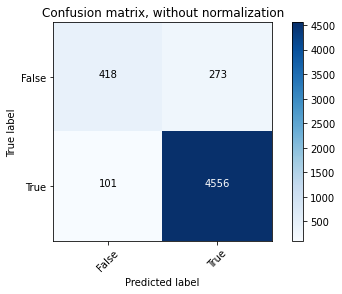

In [307]:
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

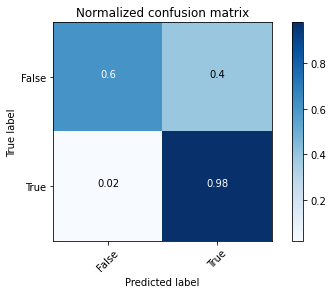

In [308]:
cnf_matrix_norm = cnf_matrix/np.sum(cnf_matrix, axis = 1, keepdims = True)

# do not modify below this line
plot_confusion_matrix(cnf_matrix_norm, classes=class_names,
                       title='Normalized confusion matrix')